In [ ]:
using Distributions
import Distributions: Uniform

In [2]:
mutable struct Vec
    x::Float64
    y::Float64
end

function bound(vec::Vec)
    vec.x = clamp(vec.x, -1, 1)
    vec.y = clamp(vec.y, -1, 1)
    return vec
end
    
(Base.:+)(a::Vec, b::Vec) = bound(Vec(a.x + b.x, a.y + b.y))
(Base.:-)(a::Vec, b::Vec) = bound(Vec(a.x - b.x, a.y - b.y))
(Base.:*)(a::Vec, b::Float64) = bound(Vec(a.x * b, a.y * b))
(Base.:*)(a::Vec, b::Int) = bound(a * convert(Float64, b))

struct InfParticle end

In [14]:
mutable struct Particle
    position::Vec
    best::Vec
    v::Vec
end


mutable struct Swarm 
    particles::Vector{Particle}
    best::Particle
end


function make_particle()
    x, y = rand(Uniform(-1,1)), rand(Uniform(-1,1))
    vx, vy = rand(Uniform(-1,1)), rand(Uniform(-1,1))
    position = Vec(x, y)
    best = Vec(x, y)
    v = Vec(vx, vy)
    Particle(position, best, v)
end

(f)(x::Float64, y::Float64) = x^4 - x^2 + y^2
(f)(position::Vec) = f(position.x, position.y)
(f)(particle::Particle) = f(particle.position)
(f)(particle::InfParticle) = Inf

(make_velocity_noise)(scale) = Vec(rand(Uniform(-1,1))*scale, rand(Uniform(-1,1))*scale)

function find_best(arr::Vector)
    best = InfParticle()
    for p in arr
        if f(p) < f(best)
            best = p
        end
    end
    return best
end
    
function make_swarm(n::Int)
    particles = [make_particle() for _ in 1:n]
    best = find_best(particles)
    Swarm(particles, best)
end

make_swarm (generic function with 1 method)

In [24]:
function step(swarm::Swarm; w=0.8, theta=0.18, phi=0.02)
    noise = 0.03
    for p in swarm.particles
        v0 = p.v * w
        vp = ((p.best - p.position) * theta) + make_velocity_noise(noise)
        vg = ((swarm.best.position - p.position) * phi) + make_velocity_noise(noise)
        p.v = v0 + vp + vg
        p.position = p.position + p.v
        z = f(p)
        if z < f(p.best)
            p.best = p.position
            if z < f(swarm.best)
                swarm.best = p
            end
        end
    end
end

step (generic function with 1 method)

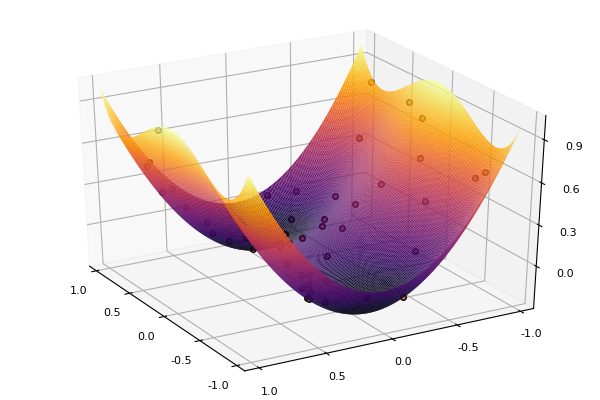

In [34]:
using Plots
pyplot()

swarm = make_swarm(50)

x = range(-1, stop=1, step=0.01)
y = range(-1, stop=1, step=0.01)
contour(x, y, f, st=:surface, linealpha=0.1, fillalpha=0.1, legend=:none)
X = [p.position.x for p in swarm.particles]
Y = [p.position.y for p in swarm.particles]
Z = [f(p) for p in swarm.particles]
plot!(X, Y, Z, st=:scatter, camera=(-120, 30), fillalpha=0.9, legend=:none)

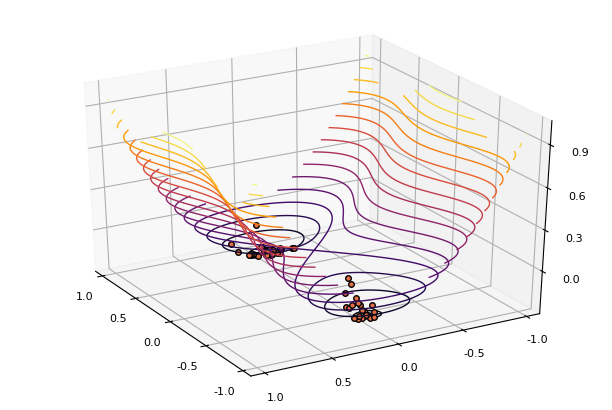

┌ Info: Saved animation to 
│   fn = /Users/adammarples/playground/PSO/anim.gif
└ @ Plots /Users/adammarples/.julia/packages/Plots/Xnzc7/src/animation.jl:104


Plots.AnimatedGif("/Users/adammarples/playground/PSO/anim.gif")
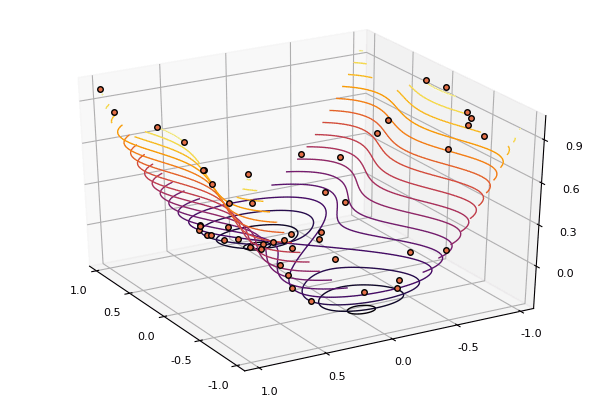

In [35]:
anim = @animate for i ∈ 1:75
    step(swarm)
    contour(x, y, f, legend=:none)
    X = [p.position.x for p in swarm.particles]
    Y = [p.position.y for p in swarm.particles]
    Z = [f(p) for p in swarm.particles]
    plot!(X, Y, Z, st=:scatter, camera=(-120, 30), legend=:none)
end
gif(anim, "anim.gif", fps = 30)